In [1]:
import pandas as pd
import torch
import json
import numpy as np
from torch.utils.data import random_split, DataLoader
from neural_test import train_model, test_model, CustomDataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

In [116]:
class DynamicNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(DynamicNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers

        # Create the first layer
        self.layers = [torch.nn.Linear(input_size, hidden_size), torch.nn.ReLU()]

        # Create the hidden layers
        for _ in range(num_hidden_layers):
            self.layers.append(torch.nn.Linear(hidden_size, hidden_size))
            self.layers.append(torch.nn.ReLU())

        # Create the output layer
        self.layers.append(torch.nn.Linear(hidden_size, output_size))

        # Combine all layers
        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, x):
        out = self.model(x)
        if not self.training:
            out = torch.clamp(out, min=1, max=5)
        return out

In [3]:
device = "cpu"
# Load JSON data
with open('restaurant-topic-sentiment.json') as file:
    json_data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame.from_dict(json_data, orient='index')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert DataFrame to numpy array
data = df.to_numpy()
df.head()

,pos_food,pos_service,pos_location,pos_clean,pos_price,neg_food,neg_service,neg_location,neg_clean,neg_price,rating
0,1.538462,0.538462,0.153846,0.076923,0.000000,0.538462,0.076923,0.000000,0.000000,0.076923,4.3
1,1.525641,0.474359,0.487179,0.038462,0.141026,0.397436,0.025641,0.000000,0.000000,0.025641,4.6
2,0.850746,0.317164,0.220149,0.014925,0.197761,0.373134,0.156716,0.070896,0.003731,0.085821,4.2
3,0.431373,0.196078,0.039216,0.039216,0.039216,0.078431,0.078431,0.000000,0.019608,0.039216,4.2
4,1.000000,0.533333,0.616667,0.000000,0.116667,0.533333,0.200000,0.133333,0.000000,0.233333,4.1


In [117]:
input_dim = 10
hidden_dim = 4
num_hidden_layers = 2
output_dim = 1
learningRate = .01
epochs = 150

lambda1 = 0.0000 # l1 regularization parameter (sum of weights)
lambda2 = 0.0000 # l2 regularization parameter (sum of square of weights)

model = DynamicNN(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

# Split the dataset
train_data, test_data = random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_dataset = CustomDataset(np.array(train_data))
test_dataset = CustomDataset(np.array(test_data))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# train the model on train set
model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)

# test the model on test set
all_predictions, all_labels, all_inputs = test_model(model, test_loader)

mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

IndexError: list index out of range

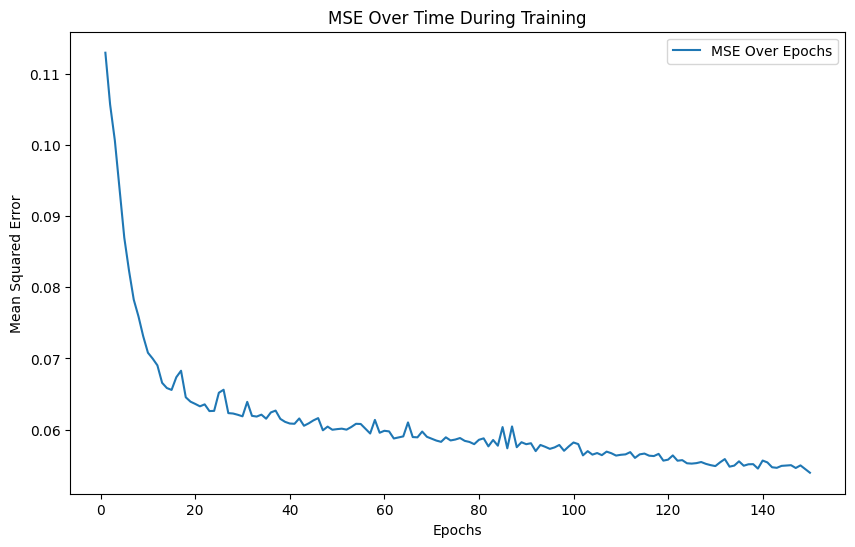

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), mse_history, label='MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Time During Training')
plt.legend()
plt.show()

In [111]:
k_folds = 5
# Create KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

models: list[torch.nn.Module] = []

for fold, (train_ids, test_ids) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    train_dataset = CustomDataset(data[train_ids])
    test_dataset = CustomDataset(data[test_ids])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    model = DynamicNN(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)
    # train the model on train set
    model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)
    
    # test the model on test set
    all_predictions, all_labels, all_inputs = test_model(model, test_loader)
    
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_labels, all_predictions)
    
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')

    models.append(model)


Fold 1/5
Mean Squared Error: 0.05190790072083473
Root Mean Squared Error: 0.22783304750919342
R-squared: 0.702834261763199
Fold 2/5
Mean Squared Error: 0.04923442751169205
Root Mean Squared Error: 0.22188831865787506
R-squared: 0.68847090938585
Fold 3/5
Mean Squared Error: 0.12242573499679565
Root Mean Squared Error: 0.3498938977718353
R-squared: 0.30428199992515403
Fold 4/5
Mean Squared Error: 0.10796113312244415
Root Mean Squared Error: 0.32857438921928406
R-squared: 0.45351946774113117
Fold 5/5


KeyboardInterrupt: 

In [6]:
best = models[0] # choose the best model here
# torch.save(best.state_dict(), "nn4_40.pt")

In [7]:
# model = DynamicNN(10, 40, 1, 4).to(device)
# model.load_state_dict(torch.load('nn4_40.pt'))
# torch.cat([x.view(-1) for x in model.parameters()]).tolist()

In [9]:

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        if not self.training:
            out = torch.clamp(out, min=1, max=5)
        return out

In [10]:
# Load JSON data
with open('restaurant-topic-sentiment.json') as file:
    json_data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame.from_dict(json_data, orient='index')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert DataFrame to numpy array
data = df.to_numpy()
df.head()

,pos_food,pos_service,pos_location,pos_clean,pos_price,neg_food,neg_service,neg_location,neg_clean,neg_price,rating
0,1.538462,0.538462,0.153846,0.076923,0.000000,0.538462,0.076923,0.000000,0.000000,0.076923,4.3
1,1.525641,0.474359,0.487179,0.038462,0.141026,0.397436,0.025641,0.000000,0.000000,0.025641,4.6
2,0.850746,0.317164,0.220149,0.014925,0.197761,0.373134,0.156716,0.070896,0.003731,0.085821,4.2
3,0.431373,0.196078,0.039216,0.039216,0.039216,0.078431,0.078431,0.000000,0.019608,0.039216,4.2
4,1.000000,0.533333,0.616667,0.000000,0.116667,0.533333,0.200000,0.133333,0.000000,0.233333,4.1


In [11]:
input_dim = 10
output_dim = 1
learningRate = .015
epochs = 100

lambda1 = 0.0000 # l1 regularization parameter (sum of weights)
lambda2 = 0.0000 # l2 regularization parameter (sum of square of weights)

model = linearRegression(input_dim, output_dim).to(device)

k_folds = 5
# Create KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

models: list[torch.nn.Module] = []

for fold, (train_ids, test_ids) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    train_dataset = CustomDataset(data[train_ids])
    test_dataset = CustomDataset(data[test_ids])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # train the model on train set
    model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)
    
    # test the model on test set
    all_predictions, all_labels, all_inputs = test_model(model, test_loader)
    
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_labels, all_predictions)
    
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')

    models.append(model)


Fold 1/5
Mean Squared Error: 0.0509042926132679
Root Mean Squared Error: 0.22561979293823242
R-squared: 0.7085797495402048
Fold 2/5
Mean Squared Error: 0.051358532160520554
Root Mean Squared Error: 0.22662420570850372
R-squared: 0.6750307104031648
Fold 3/5
Mean Squared Error: 0.06284027546644211
Root Mean Squared Error: 0.2506796419620514
R-squared: 0.6428927794767072
Fold 4/5
Mean Squared Error: 0.058825936168432236
Root Mean Squared Error: 0.24254058301448822
R-squared: 0.7022333030315527
Fold 5/5
Mean Squared Error: 0.06556093692779541
Root Mean Squared Error: 0.25604870915412903
R-squared: 0.630688933268333


In [12]:
#best = models[0]
torch.cat([x.view(-1) for x in models[0].parameters()]).tolist()
# torch.save(best.state_dict(), "linear.pt")

[0.42292335629463196,
 0.28322964906692505,
 0.3203519880771637,
 -0.06150068715214729,
 -0.027078554034233093,
 -0.7879498600959778,
 -0.8423044681549072,
 -0.26466625928878784,
 -0.6685864925384521,
 -0.21184946596622467,
 4.01657247543335]

In [13]:
model = DynamicNN(10, 40, 1, 4).to(device)
model.load_state_dict(torch.load('linear.pt'))
torch.cat([x.view(-1) for x in model.parameters()]).tolist()

RuntimeError: Error(s) in loading state_dict for DynamicNN:
	Missing key(s) in state_dict: "model.0.weight", "model.0.bias", "model.2.weight", "model.2.bias", "model.4.weight", "model.4.bias", "model.6.weight", "model.6.bias", "model.8.weight", "model.8.bias", "model.10.weight", "model.10.bias". 
	Unexpected key(s) in state_dict: "linear.weight", "linear.bias". 